<a href="https://colab.research.google.com/github/SergeiVKalinin/PNNL_ML_2024/blob/main/Day_2_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Tutorial notebook for the PNNL Summer ML course

- Instructor Sergei V. Kalinin, sergei2@utk.edu

- These examples and visualization functions are from the Sebastian Rashka book, Chapter 1

https://subscription.packtpub.com/book/data/9781801819312/pref/preflvl1sec03/what-this-book-covers

# Perceptron and Adaline

## Simple Perceptron

First, let's have a look at a simple perceptron. Note:
- how the weights and bias are initialized
- what happens during the fit
- what happens during predict

In [1]:
import numpy as np

class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of
          examples and n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
                              size=X.shape[1])
        self.b_ = np.float_(0.)
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)


Let's import the Iris data set

In [2]:
import os
import pandas as pd

s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('From URL:', s)

df = pd.read_csv(s,header=None,encoding='utf-8')
df.tail()

From URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


Now, let's plot the subset of the data, namely petal and sepal length for Setosa and Versicolor

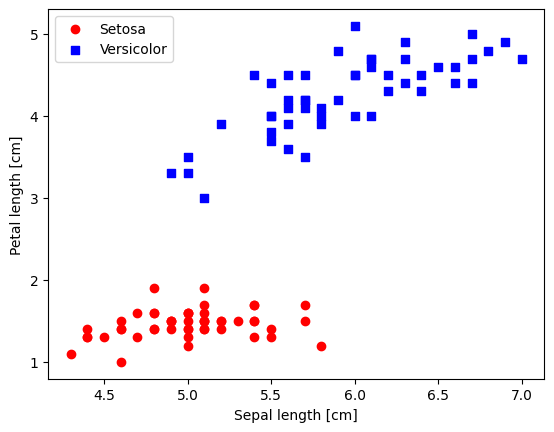

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='s', label='Versicolor')
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.show()

Now, let's fit! For example below, experiment with
- values of eta (learning rate), say from 0.0001, 0.001, .., 10
- number of iterations, e.g. 10, 100, 1000
- what happens is eta is too small? too large?

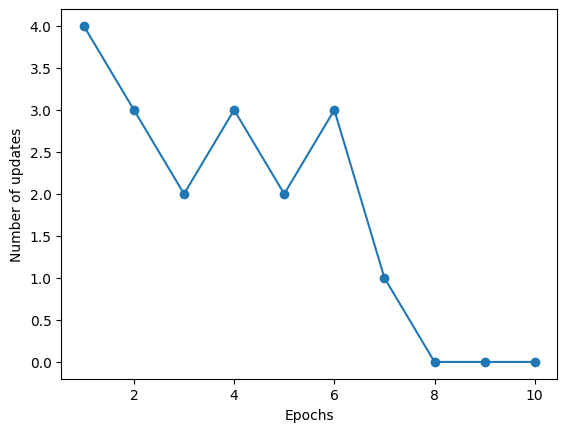

In [4]:
ppn = Perceptron(eta=0.001, n_iter=10)
ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

This is the function to plot decision regions:

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)

    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

Let's see how perceptron separates two classes:

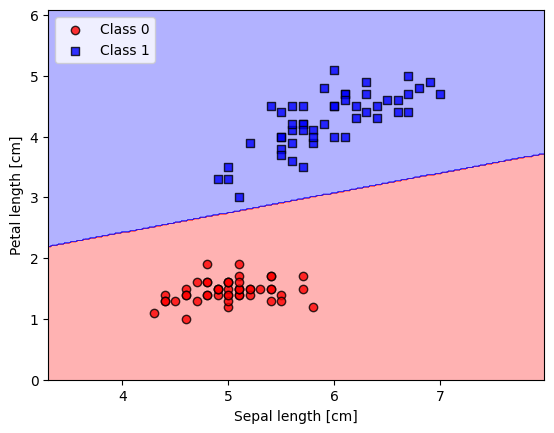

In [6]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.show()

## Adaline

Now, let's have a look at the adaline algorithm. Compare it with the perceptron.
- compare how the weights are updated
- compare the error signal

In [7]:
class AdalineGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator seed for random weight initialization.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function values in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples
            is the number of examples and
            n_features is the number of features.
        y : array-like, shape = [n_examples]
            Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
                              size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X))
                        >= 0.5, 1, 0)


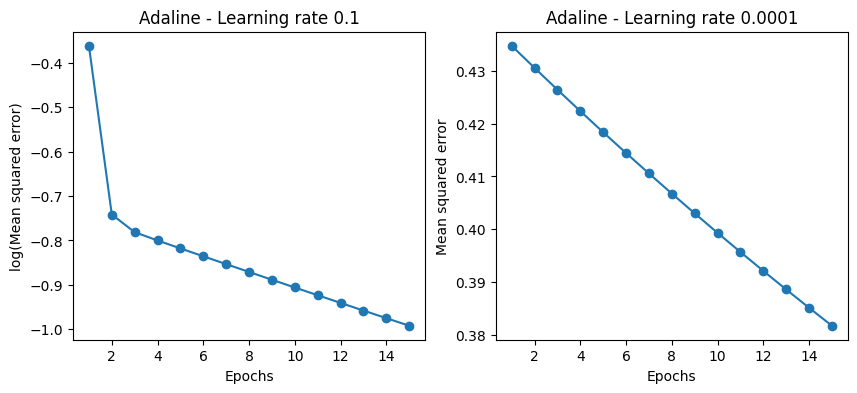

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=15, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), np.log10(ada1.losses_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Mean squared error)')
ax[0].set_title('Adaline - Learning rate 0.1')

ada2 = AdalineGD(n_iter=15, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')
plt.show()

In [9]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

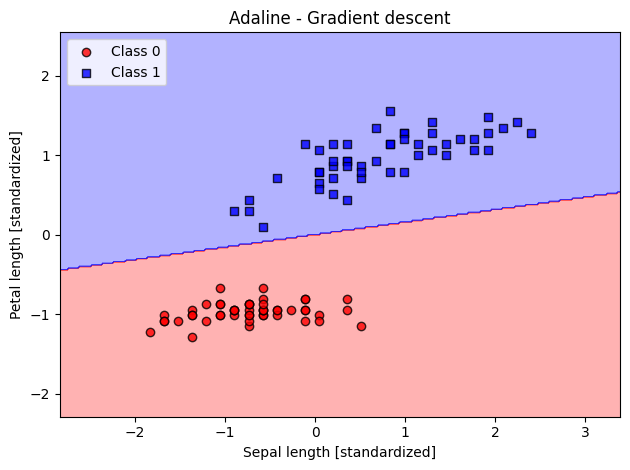

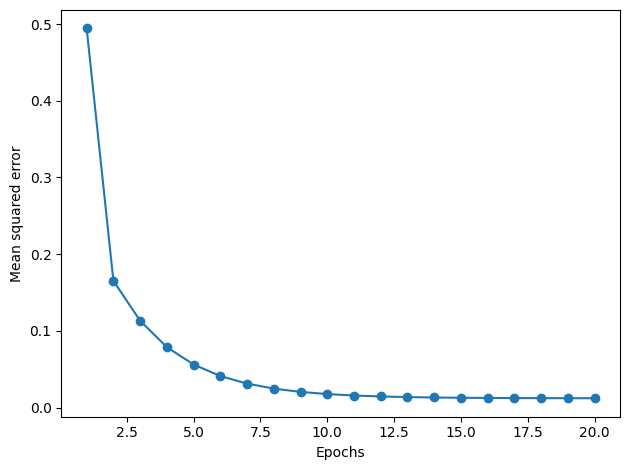

In [10]:
ada_gd = AdalineGD(n_iter=20, eta=0.5)
ada_gd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.tight_layout()
plt.show()

## Perceptron in Scikit-Learn

In [11]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


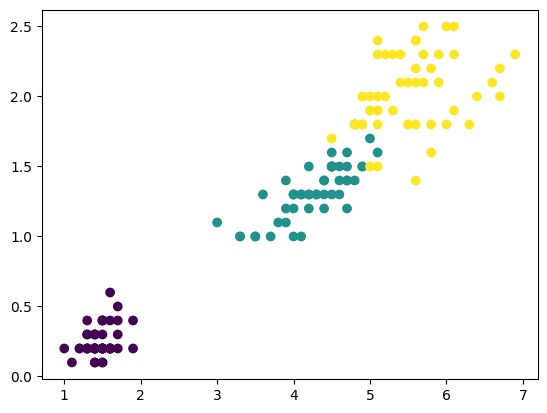

In [12]:
plt.scatter(X[:,0], X[:,1], c = y)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [14]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [15]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [16]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [17]:
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 1


In [18]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.978


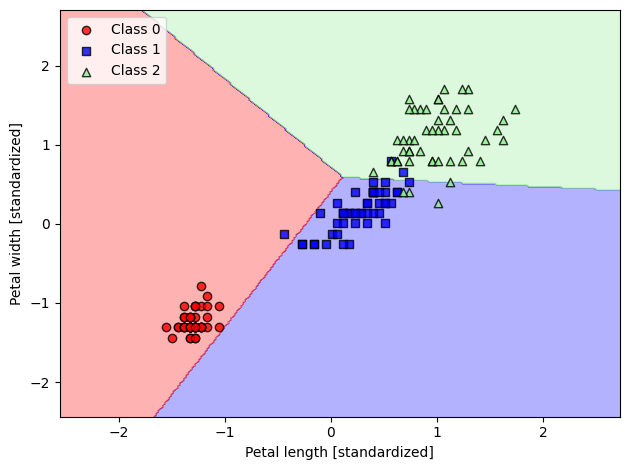

In [19]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn) #, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
help(Perceptron)

Help on class Perceptron in module sklearn.linear_model._perceptron:

class Perceptron(sklearn.linear_model._stochastic_gradient.BaseSGDClassifier)
 |  Perceptron(*, penalty=None, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, eta0=1.0, n_jobs=None, random_state=0, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False)
 |  
 |  Linear perceptron classifier.
 |  
 |  Read more in the :ref:`User Guide <perceptron>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  penalty : {'l2','l1','elasticnet'}, default=None
 |      The penalty (aka regularization term) to be used.
 |  
 |  alpha : float, default=0.0001
 |      Constant that multiplies the regularization term if regularization is
 |      used.
 |  
 |  l1_ratio : float, default=0.15
 |      The Elastic Net mixing parameter, with `0 <= l1_ratio <= 1`.
 |      `l1_ratio=0` corresponds to L2 penalty, `l1_ratio=1` to L1.
 |      Only used if 

# Linear and Logistics Regression

**Remember** that logistics regression is classification method (despite the name)!

## Simple linear regression

In [21]:
import numpy as np

num1=20
num2=20

x1 = np.linspace(0, 10, num1)
x2 = np.linspace(-3, 3, num2)

x = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)
y = 2 * x[:, 0] + 3 * x[:, 1] + 5 + 10*np.random.randn(num1*num2)

In [22]:
x1.shape, x2.shape, x.shape, y.shape

((20,), (20,), (400, 2), (400,))

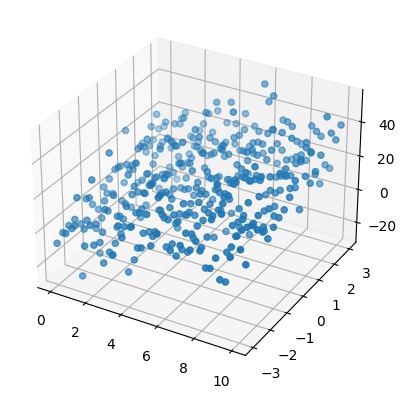

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], y)
plt.show()

In [24]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x, y)

print(model.coef_)
print(model.intercept_)

[2.15651654 2.70428329]
4.808941097919162


## Linear regression - RANSAC

In [25]:
import pandas as pd

X = np.random.uniform(0, 100, 100)
x1 = np.random.choice([0, 1], 100, p=[0.8, 0.2])
y = 2*X - 3*x1*X + 5 + np.random.randn(100)

df = pd.DataFrame({"x":X, "x1":x1, "y":y})

df.head(10)

,x,x1,y
0,74.339394,0,153.613819
1,85.720740,0,176.881477
2,66.506399,1,-59.658096
3,46.295671,0,99.418324
4,31.345194,0,66.737469
5,10.872818,0,26.915087
6,29.384977,0,64.195163
7,1.406357,0,7.858415
8,97.898283,0,201.908555
9,9.569803,0,24.522016


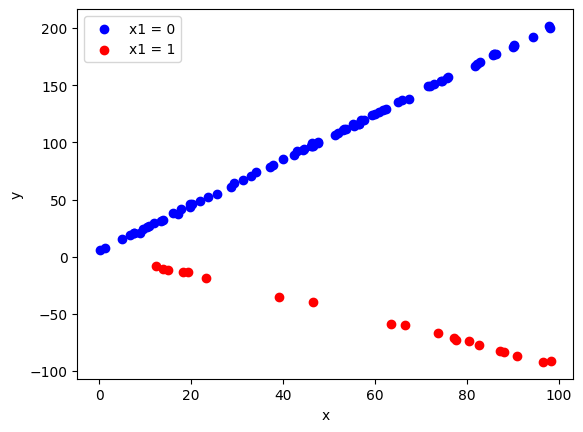

In [26]:
plt.scatter(df[df['x1'] == 0]['x'], df[df['x1'] == 0]['y'], color='blue', label='x1 = 0')
plt.scatter(df[df['x1'] == 1]['x'], df[df['x1'] == 1]['y'], color='red', label='x1 = 1')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()

In [27]:
from sklearn.linear_model import RANSACRegressor

X = np.array(df['x']).reshape(-1, 1)
y = np.array(df['y']).reshape(-1, 1)

ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=0.90,
                         residual_threshold=None,
                         random_state=123)

ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.9, random_state=123)

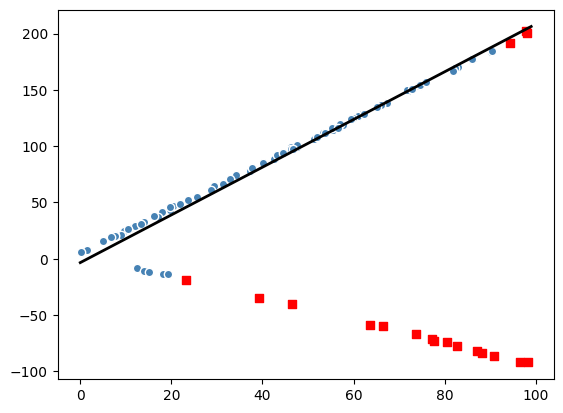

In [28]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(0, 100, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')

plt.scatter(X[outlier_mask], y[outlier_mask],
            c='red', edgecolor='red',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.show()

## Logistic regression in scikit-learn

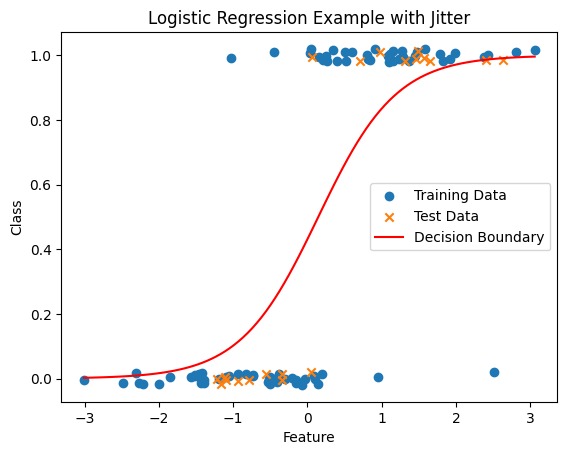

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Generate synthetic data
random_seed = 16
X, y = make_classification(n_samples=100,
                           n_features=1,
                           n_informative=1,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=random_seed)

# Add jitter to y-coordinates for visualization
jitter = 0.02
jitter_array = np.random.uniform(-jitter, jitter, size=y.shape)
y = y.astype(float) + jitter_array

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train, np.round(y_train).astype(int))

# Generate data points for the decision boundary
x_range = np.linspace(X.min(), X.max(), 100)
y_pred = model.predict_proba(x_range.reshape(-1, 1))[:, 1]

# Plot the data points and the decision boundary
plt.scatter(X_train, y_train, label='Training Data', marker='o')
plt.scatter(X_test, y_test, label='Test Data', marker='x')
plt.plot(x_range, y_pred, color='red', label='Decision Boundary')
plt.xlabel('Feature')
plt.ylabel('Class')
plt.title('Logistic Regression Example with Jitter')
plt.legend()
plt.show()

In [30]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [31]:
model.coef_, model.intercept_

(array([[1.8995887]]), array([-0.27880469]))

Now, let's try it on Iris data set. Logistic function can be applied to multiple classes

In [32]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


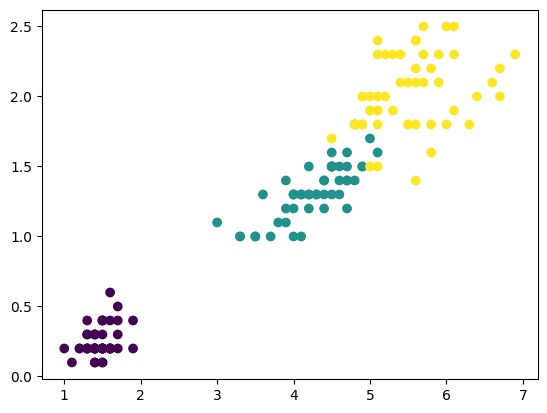

In [33]:
plt.scatter(X[:,0], X[:,1], c = y)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [35]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [36]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [37]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None,
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')

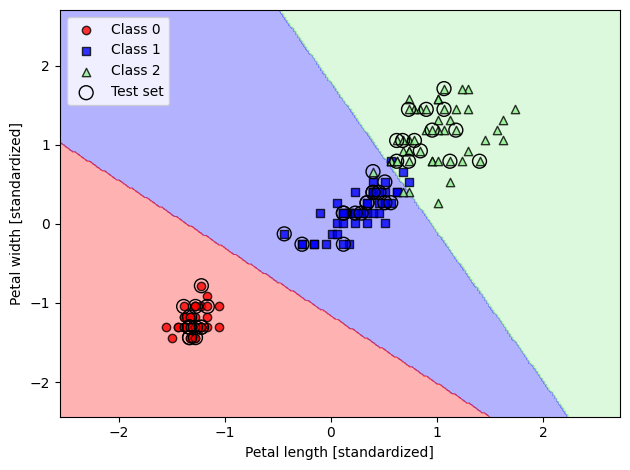

In [38]:
from sklearn.linear_model import LogisticRegression

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

lr = LogisticRegression(C=100, solver='lbfgs',multi_class='multinomial') #'multinomial' 'ovr'
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Let's predict class membership probabilities for first 5 flowers:

In [39]:
lr.predict_proba(X_test_std[:5, :])

array([[1.52213484e-12, 3.85303417e-04, 9.99614697e-01],
       [9.93560717e-01, 6.43928295e-03, 1.14112016e-15],
       [9.98655228e-01, 1.34477208e-03, 1.76178271e-17],
       [3.79431985e-06, 9.04401285e-01, 9.55949212e-02],
       [5.22212406e-05, 9.94209099e-01, 5.73867966e-03]])

And identify the classes as argmax

In [40]:
lr.predict_proba(X_test_std[:5, :]).argmax(axis=1)

array([2, 0, 0, 1, 1])

- We can get the same answer if we use predict() method
- Note that we have to use .reshape(1,-1) to get correct dimensionality

In [41]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

In [42]:
X_test_std[0, :].reshape(1, -1).shape, X_test_std[0, :].shape, X_test_std[0:3, :].shape

((1, 2), (2,), (3, 2))

Note that parameter C defines the regularization in logistic regression (inverse weight coefficient).
- Experiment with different C values for code above!
- Below we show weight coefficient vs. C

# ROC and AUC

## Logistics classification in 1D

Let's start with creating a simple data set with 1D feature space and logistic classifier. We add some jitter to the data to make visualization easier.

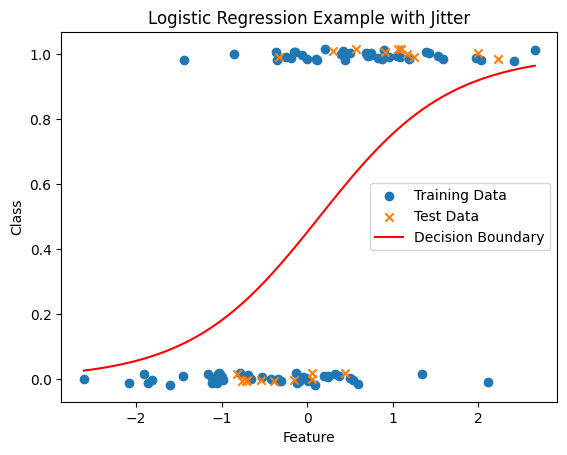

In [43]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Generate synthetic data
random_seed = 16
X, y = make_classification(n_samples=100,
                           n_features=1,
                           n_informative=1,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           class_sep = 0.6,
                           random_state=random_seed)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Generate data points for the decision boundary
x_range = np.linspace(X.min(), X.max(), 100)
y_pred = model.predict_proba(x_range.reshape(-1, 1))[:, 1]

# Jitter array
jitter = 0.02
jitter_array_test = np.random.uniform(-jitter, jitter, size=y_test.shape)
jitter_array_train = np.random.uniform(-jitter, jitter, size=y_train.shape)

# Plot the data points and the decision boundary
plt.scatter(X_train, y_train + jitter_array_train, label='Training Data', marker='o')
plt.scatter(X_test, y_test + jitter_array_test, label='Test Data', marker='x')
plt.plot(x_range, y_pred, color='red', label='Decision Boundary')
plt.xlabel('Feature')
plt.ylabel('Class')
plt.title('Logistic Regression Example with Jitter')
plt.legend()
plt.show()

Now, we can claculate the confusion matrix. Note that we calculate it for the test data, not all (or train data). Experiment with:
- Parameters of generated data set (especially class_sep parameter)
- Explore the make_classification() function. What are n_samples, n_features, n_informative, n_redundant, n_clusters_per_class?
- Explore what happens if you use more points

In [44]:
from sklearn.metrics import confusion_matrix

model.fit(X_train, np.round(y_train).astype(int))
y_pred = model.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[9 1]
 [1 9]]


This is a scikit-learn approach to visualize the confusion matrix more elegantly. See what happens if the matrix is 3x3

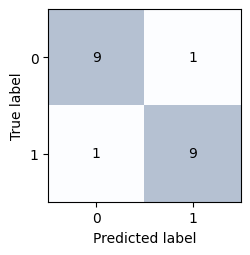

In [45]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Scikit-learn has precision, recall, f1 score, and MCC as a built-in functions. We just need to provide true and predicted labels.

In [46]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')

rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')

f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')

mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')

Precision: 0.900
Recall: 0.900
F1: 0.900
MCC: 0.800


Now, let's explore the receiver-operator characteristics (ROC) and are under the curve (AUC) for the same 1D example.

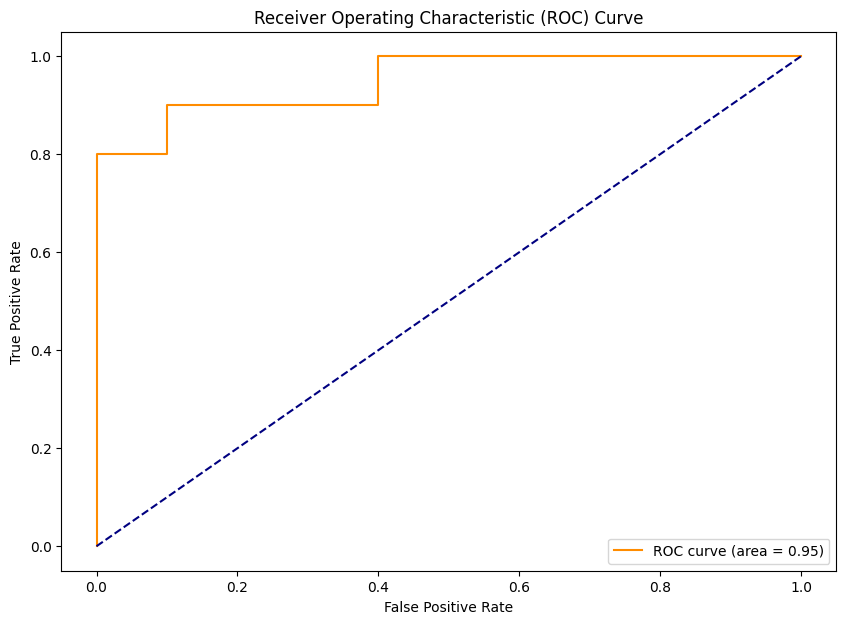

In [47]:
from sklearn.metrics import roc_curve, auc

y_test_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

# 5. Plot the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Logistics classifier in 2D

Now, let's repeat this excercise but with the 2D data. Start with the generating the data set and training the classifier.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Generate synthetic data for illustration
X, y = datasets.make_classification(n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, n_samples=3000, class_sep = 1.0, random_state=12)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Train a Logistic Regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

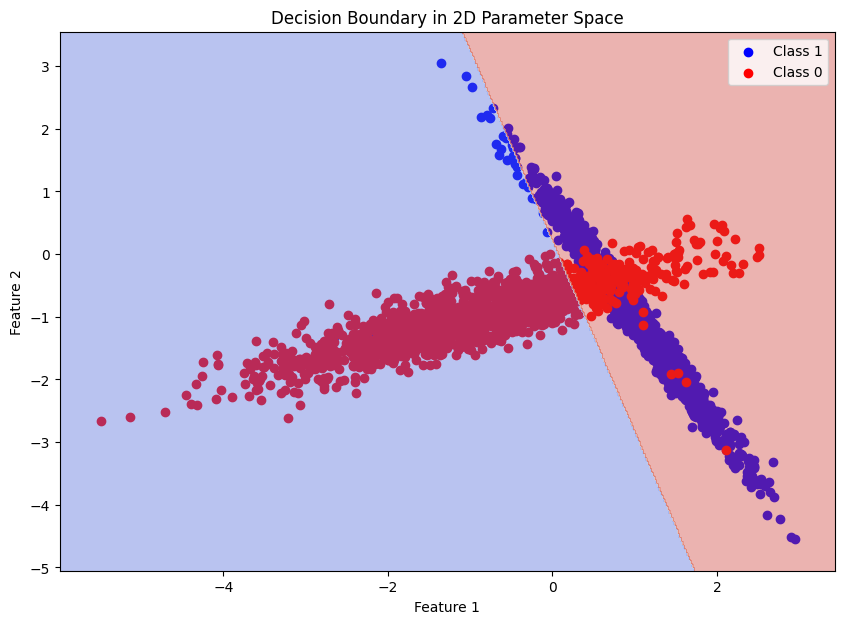

In [49]:
# Plotting the data points
fig, ax = plt.subplots(figsize=(10, 7))

# Data points by class
ax.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class 1')
ax.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Class 0')

# Decision boundary
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')

ax.legend()
ax.set_title('Decision Boundary in 2D Parameter Space')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Now, let's visualize the data distirbution, decision boundary, and true/false positives and true/false negatives. Experiment with the separation between the clusters.

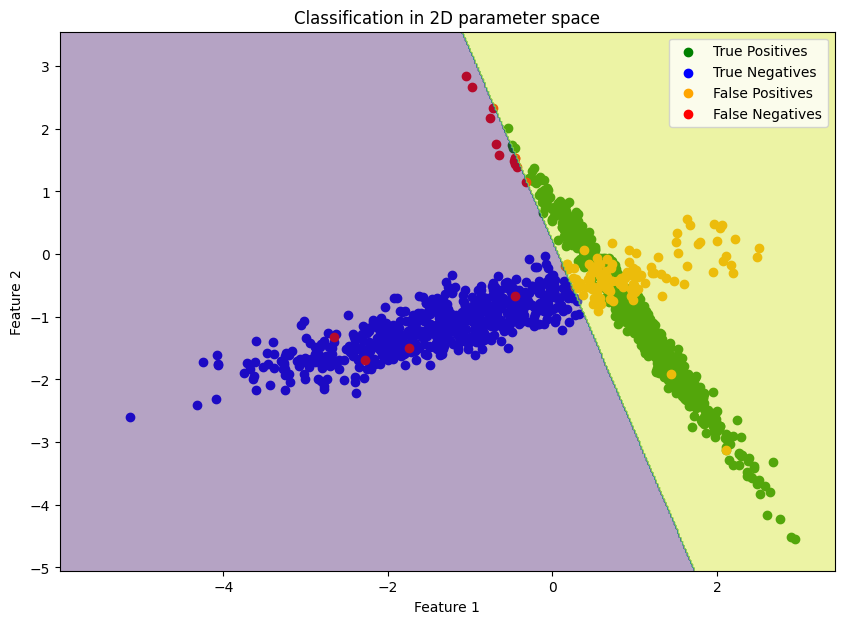

In [50]:
# Plotting the data points
fig, ax = plt.subplots(figsize=(10, 7))

# True Positives
mask_tp = np.logical_and(y_test == 1, y_pred == 1)
ax.scatter(X_test[mask_tp, 0], X_test[mask_tp, 1], color='green', label='True Positives')

# True Negatives
mask_tn = np.logical_and(y_test == 0, y_pred == 0)
ax.scatter(X_test[mask_tn, 0], X_test[mask_tn, 1], color='blue', label='True Negatives')

# False Positives
mask_fp = np.logical_and(y_test == 0, y_pred == 1)
ax.scatter(X_test[mask_fp, 0], X_test[mask_fp, 1], color='orange', label='False Positives')

# False Negatives
mask_fn = np.logical_and(y_test == 1, y_pred == 0)
ax.scatter(X_test[mask_fn, 0], X_test[mask_fn, 1], color='red', label='False Negatives')

# Decision boundary
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.4)

ax.legend()
ax.set_title('Classification in 2D parameter space')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

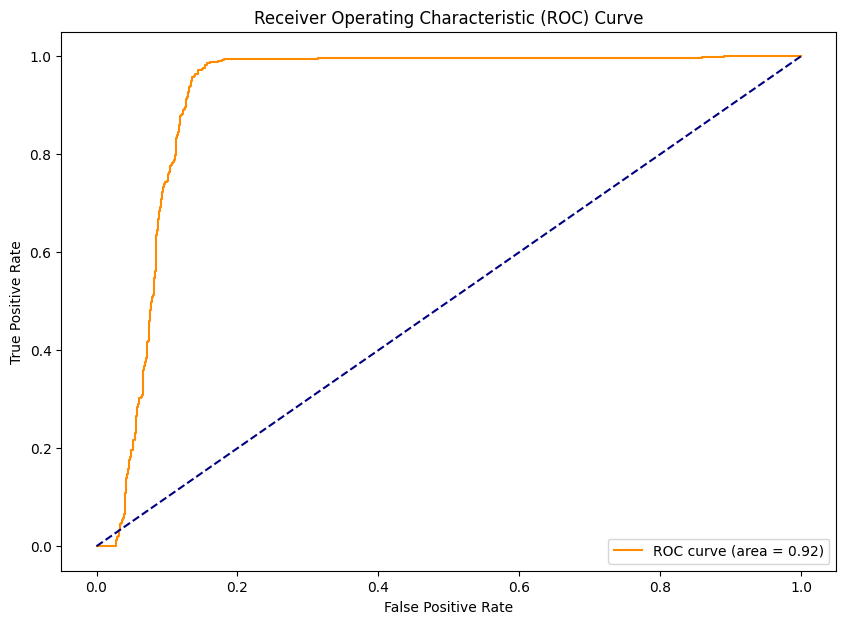

In [51]:
from sklearn.metrics import roc_curve, auc

y_test_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

# 5. Plot the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The ROC/AUC analysis works for the 2D (and any other dimension of feature space) binary classifier the same way as it does for 1D. Here, experiment with the notebook to develop the intuition regarding the behavior of the ROC curve under different scenarios. For example:
- For class_sep = 0 experiment withh n_samples=30, 300, 3000, 30000
- Experiment with larger class separations.
Ideally, you will develop intuition about "how much data" do we need to train a good classifier.  

## ROC and AUC for Decision Tree

The great thing about ROC and AUC is that we can calculate them for any other classifier. Here is the example for the decision tree.

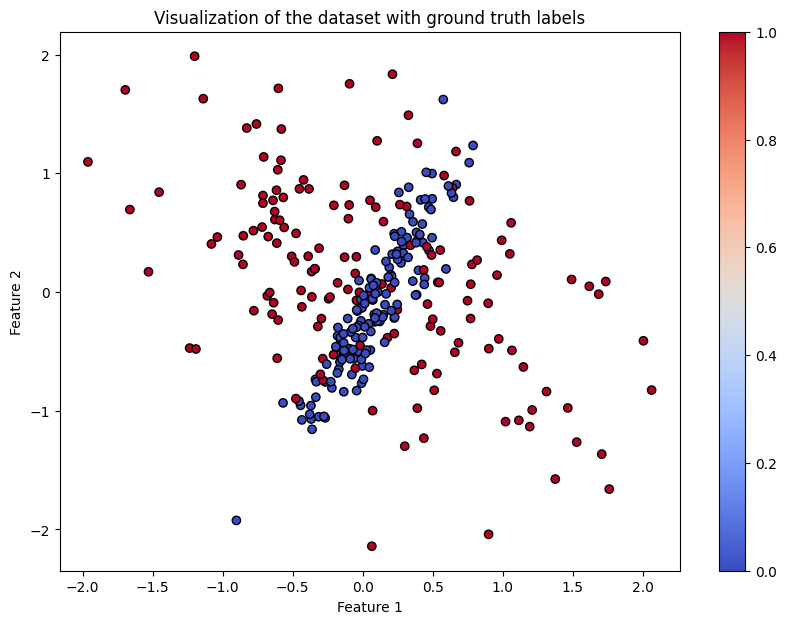

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

# 1. Generate a sample dataset
X, y = make_classification(n_samples=300, n_features=2, n_redundant = 0, n_classes=2,
                           n_clusters_per_class=1, class_sep = 0.1, random_state=42)

# Visualization of the dataset using the first two features
plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of the dataset with ground truth labels')
plt.colorbar()
plt.show()

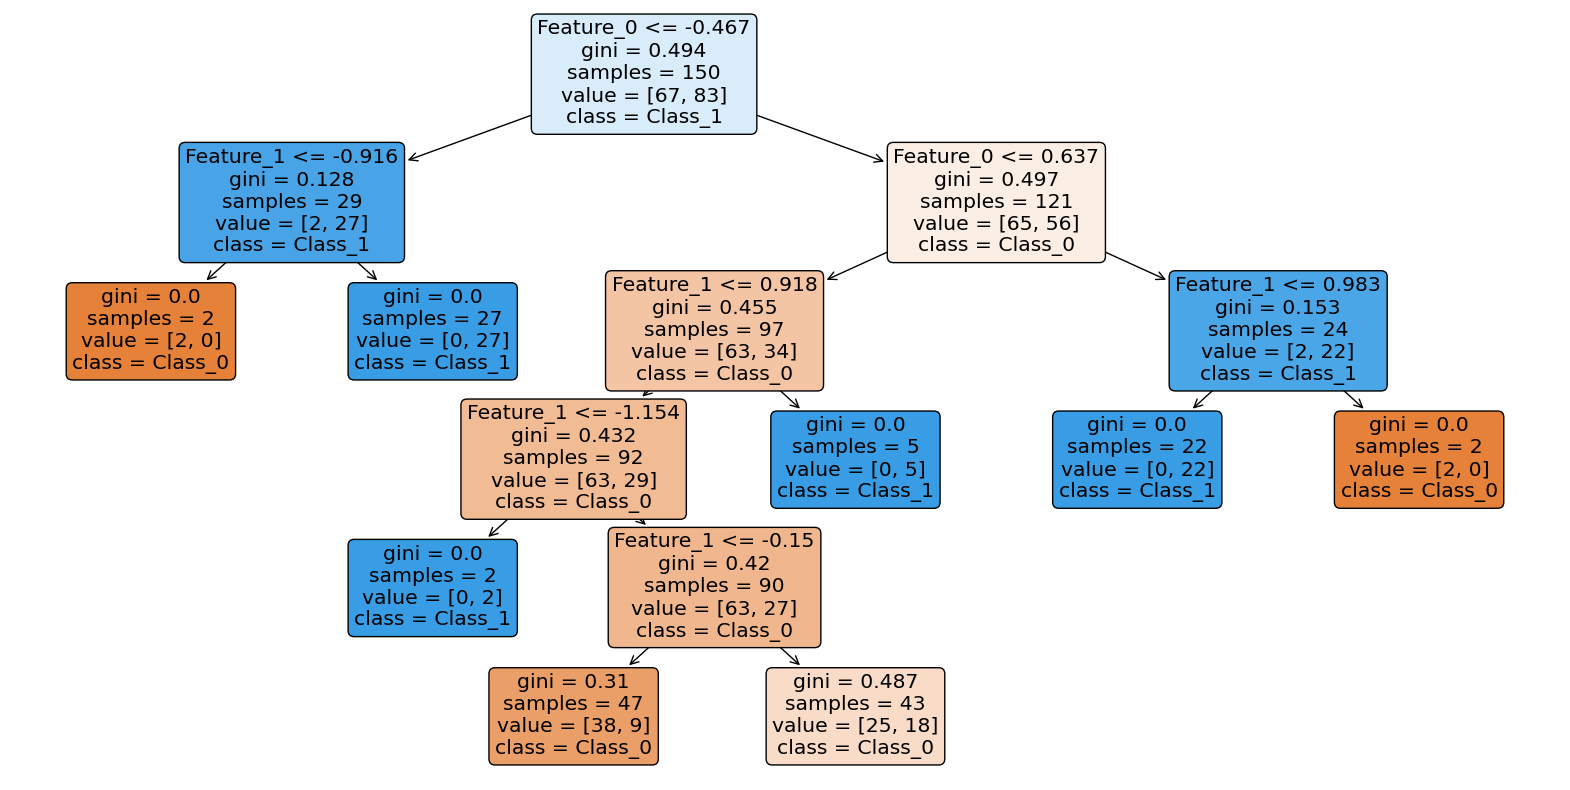

In [53]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

#Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

#Train a Decision Tree classifier
clf = DecisionTreeClassifier(max_depth = 5, random_state=42)
clf.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=[f'Feature_{i}' for i in range(X.shape[1])],
          class_names=['Class_0', 'Class_1'], rounded=True)
plt.show()

Note that the ROC curve now has a much more angular shape. This is because the decision tree ives us much less flexibility in moving decision tresholds.

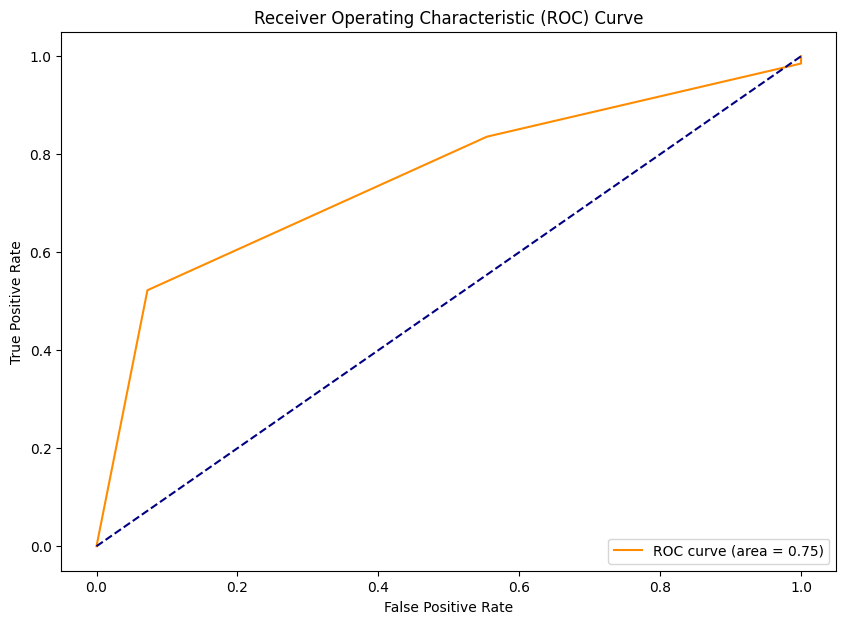

In [54]:
#Compute the ROC curve
y_test_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

#Plot the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Experiment with the:
- number of samples and
- the depth of the decision tree classifier

How does the shape of the ROC curve change if we go from 2 levels to 10 (compare with 300 and 30000 features)

## ROC and AUC for MultiClass Classification

What if we have multiple classes? In this case, we calculate multiple ROC curves - for example OvR (one vs. rest) or OvO (one vs. one)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Train a LogisticRegression classifier
clf = LogisticRegression(max_iter=1000, multi_class='ovr')  # Using One-vs-Rest approach
clf.fit(X_train, y_train)
y_score = clf.decision_function(X_test)  # This gives decision scores for each class

In [56]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

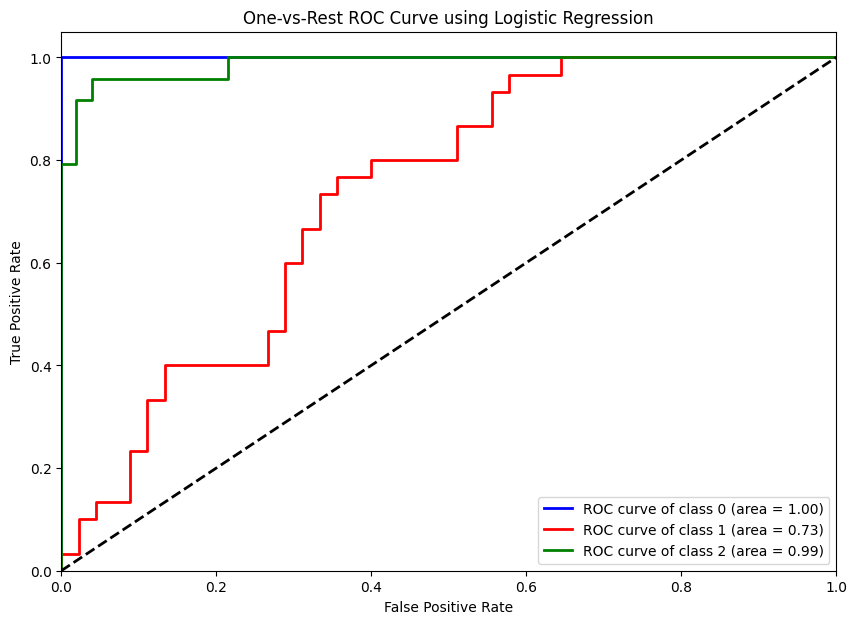

In [57]:
# Plot the ROC curves for each class
plt.figure(figsize=(10, 7))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve using Logistic Regression')
plt.legend(loc="lower right")
plt.show()

## Imbalanced classes

What if classes are imbalanced? There are multiple approaches to address this problem, but the simplest one is to balance thenumber of examples. Below you will find example of the ROC curve for imbalanced classifier, and ROC after balancing.

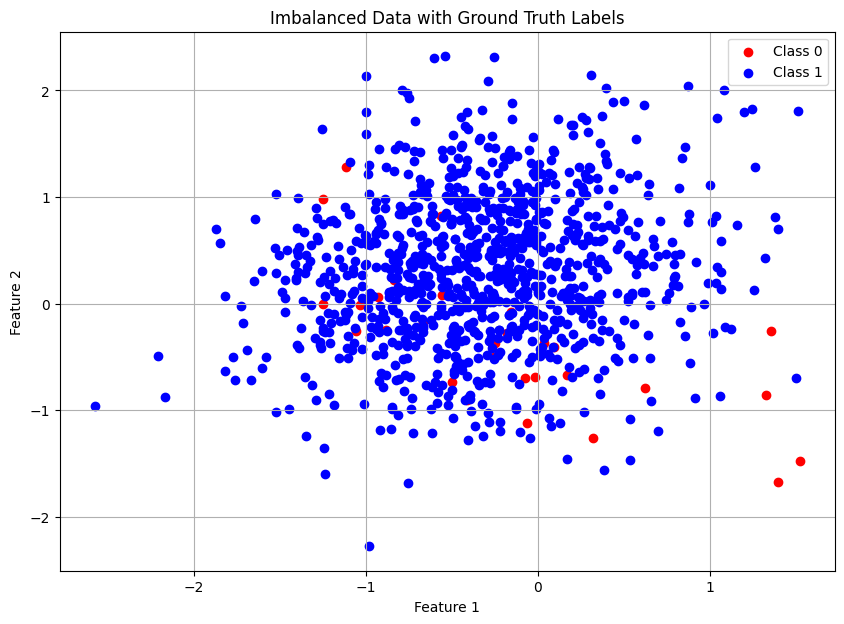

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Create an imbalanced dataset
X_imb, y_imb = make_classification(n_classes=2, class_sep=0.3, weights=[0.03, 0.97],
                           n_informative=2, n_redundant=0, flip_y=0,
                           n_features=2, n_clusters_per_class=1,
                           n_samples=1030, random_state=12)

# Split the dataset into Class 0 and Class 1 for plotting
mask_class_0 = y_imb == 0
mask_class_1 = y_imb == 1

plt.figure(figsize=(10, 7))
plt.scatter(X_imb[mask_class_0, 0], X_imb[mask_class_0, 1], color='red', label='Class 0')
plt.scatter(X_imb[mask_class_1, 0], X_imb[mask_class_1, 1], color='blue', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Imbalanced Data with Ground Truth Labels')
plt.legend()
plt.grid(True)
plt.show()

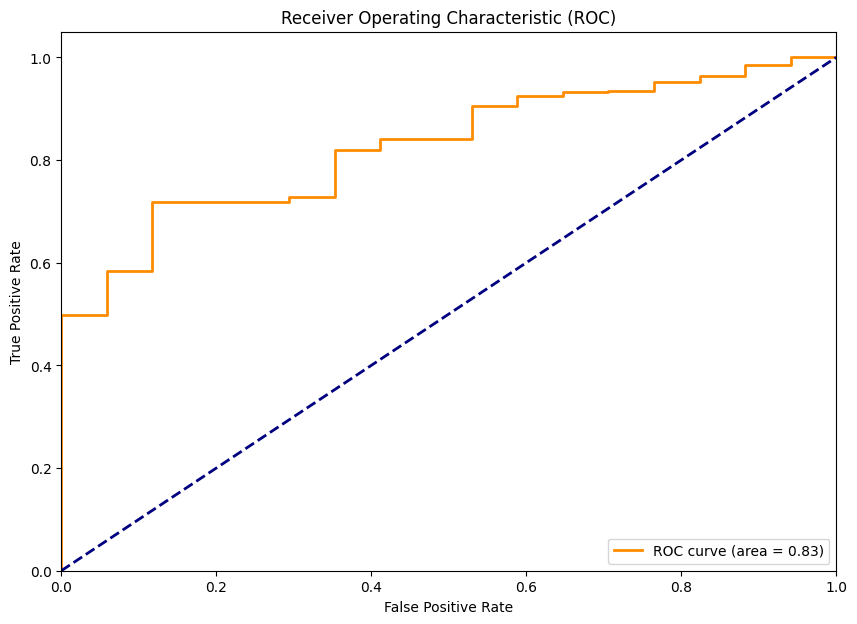

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imb, y_imb, test_size=0.5, random_state=42)

# Train a Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

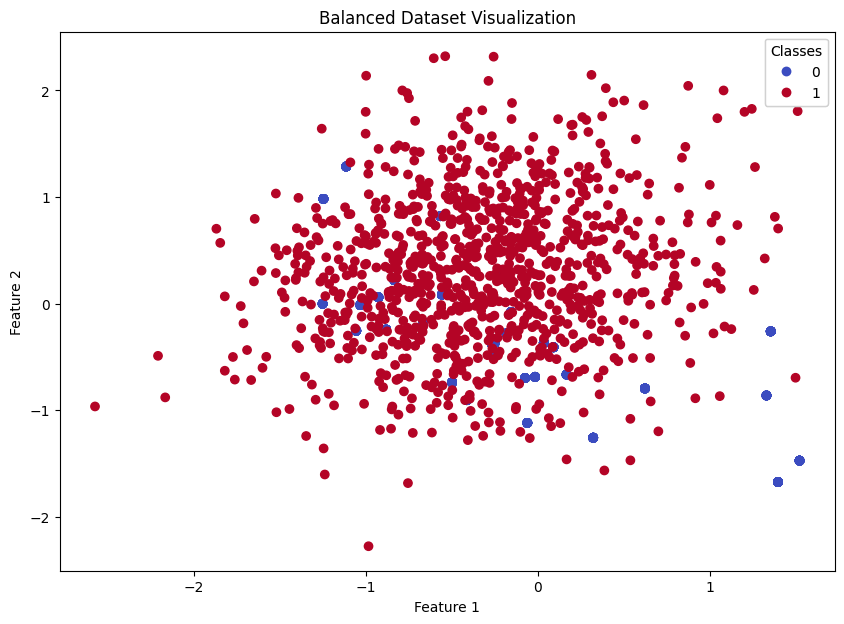

In [60]:
from sklearn.utils import resample

# Split the dataset by class
X_0 = X_imb[y_imb == 0]
X_1 = X_imb[y_imb == 1]
y_0 = y_imb[y_imb == 0]
y_1 = y_imb[y_imb == 1]

# Upsample minority class
X_0_resampled, y_0_resampled = resample(X_0, y_0,
                                       replace=True,
                                       n_samples=len(y_1),
                                       random_state=42)

# Combine the balanced data
X_balanced = np.vstack((X_0_resampled, X_1))
y_balanced = np.hstack((y_0_resampled, y_1))

# Plot the balanced dataset
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_balanced[:, 0], X_balanced[:, 1], c=y_balanced, cmap=plt.get_cmap('coolwarm'))

# Create a legend for the colors
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Balanced Dataset Visualization')
plt.show()

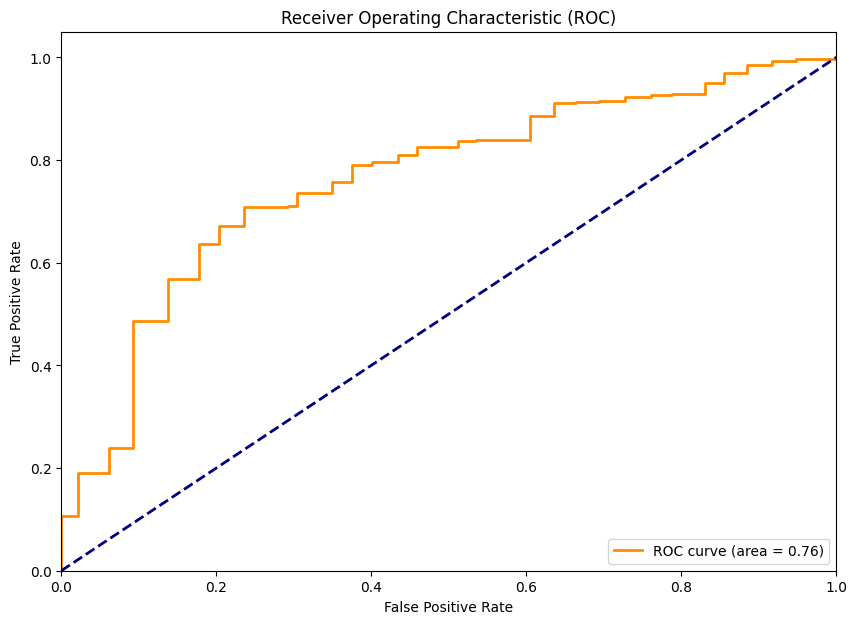

In [61]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.5, random_state=42)

# Train a Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Explaining ROC: Plot the decision boundary and class probabilities

Here we are using another very convenient function make_blobs. Note that we assign all labels 1 or higher to be 1 (otherwise we apply binary classifier to the problem that has more then 2 classes)

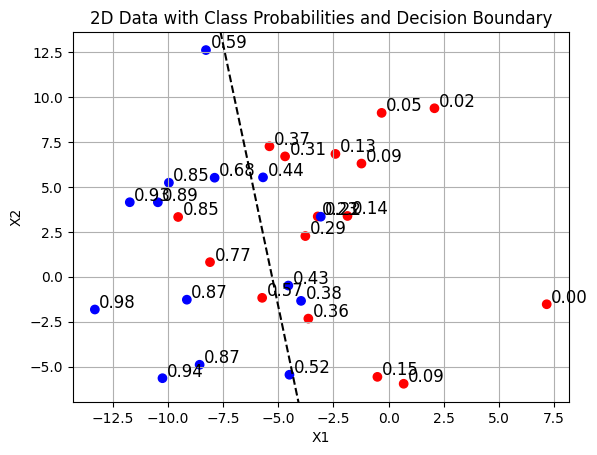

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

# Generate 2D dataset
X, y = make_blobs(n_samples=30, centers=4, random_state=22, cluster_std=3.5)

# Transform labels such that all labels 1 or larger become label 1
y[y < 2] = 0
y[y >= 2] = 1

# Train logistic regression classifier
clf = LogisticRegression()
clf.fit(X, y)

# Predict class probabilities
probs = clf.predict_proba(X)[:, 1]

# Visualize the dataset
colors = ['red' if label == 0 else 'blue' for label in y]
plt.scatter(X[:, 0], X[:, 1], color=colors)

# Plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Using the weight and bias to compute y-values along the decision boundary
x_values = np.linspace(x_min, x_max, 400)
y_values = -(clf.coef_[0][0] * x_values + clf.intercept_[0]) / clf.coef_[0][1]
plt.plot(x_values, y_values, '--k')  # '--k' means black dashed line

# Annotate each point with its class probability
for i, prob in enumerate(probs):
    plt.annotate(f'{prob:.2f}', (X[i, 0] + 0.2, X[i, 1]+0.1), fontsize=12)  # adding a small offset for clarity

plt.title('2D Data with Class Probabilities and Decision Boundary')
plt.xlabel('X1')
plt.ylabel('X2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)
plt.show()

In [63]:
np.unique(y)

array([0, 1])

# More classifiers

## Support Vector Machine

In [64]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


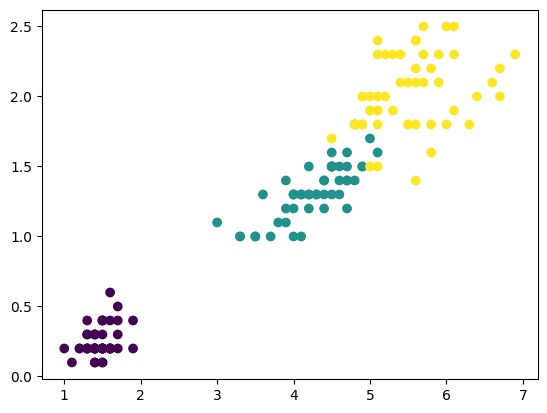

In [65]:
plt.scatter(X[:,0], X[:,1], c = y)

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [67]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [68]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [69]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None,
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')

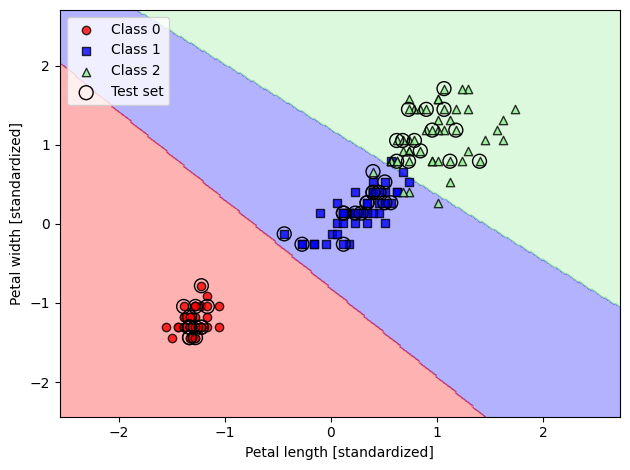

In [70]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=0.01000, random_state=1)
svm.fit(X_train_std, y_train)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

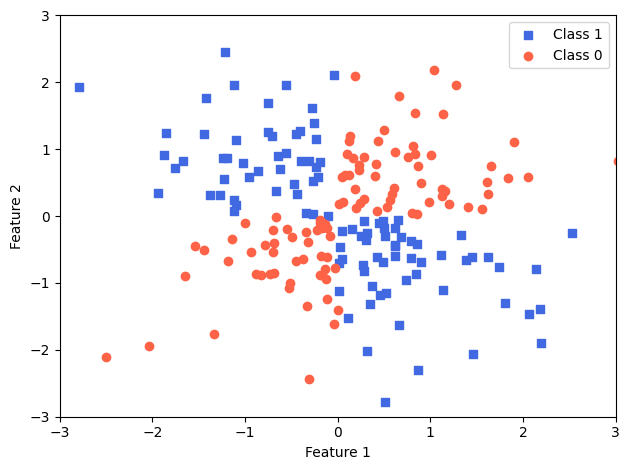

In [71]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)

plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='tomato', marker='o', label='Class 0')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

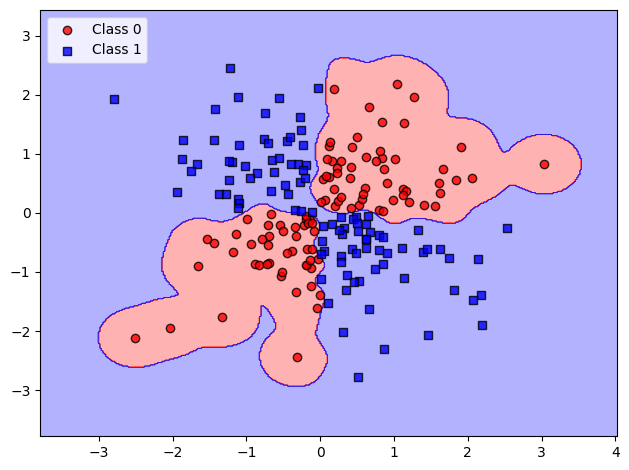

In [72]:
svm = SVC(kernel='rbf', random_state=1, gamma=10, C=10000.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

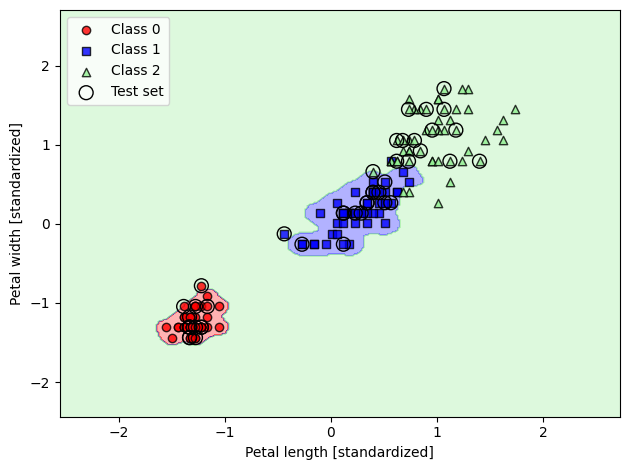

In [73]:
svm = SVC(kernel='rbf', random_state=1, gamma=100, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## kNN Classifier

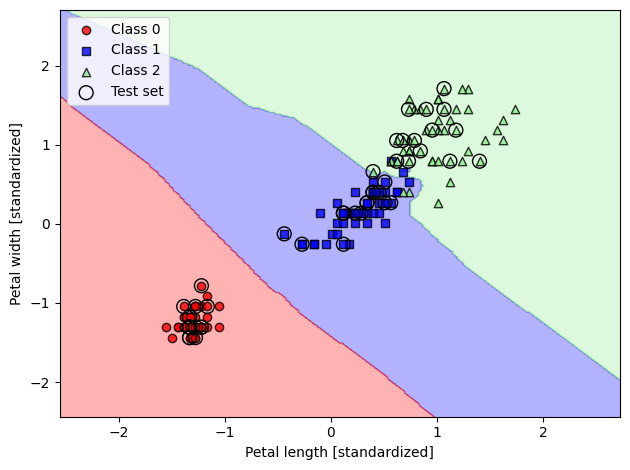

In [74]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=knn, test_idx=range(105,150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## XGBoost

In [75]:
from operator import xor
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load iris dataset
iris = datasets.load_iris()
X = iris.data[:100, :2]  # Only take the first two features, and 100 samples to include only setosa and versicolor.
y = iris.target[:100]

#or try this
'''
X = X_xor
y = y_xor
'''

# Split dataset into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [76]:
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)
gbm = model.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)
gbm_train = accuracy_score(y_train, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)
print(f'XGboost train/test accuracies ' f'{gbm_train:.3f}/{gbm_test:.3f}')

XGboost train/test accuracies 1.000/0.980


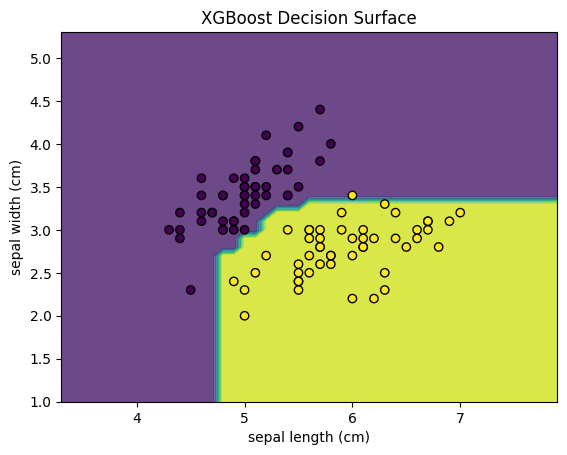

In [77]:
# Visualize decision surface
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = gbm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('XGBoost Decision Surface')
plt.show()